In [1]:
from dataclasses import dataclass
from enum import Enum
import os
import pandas as pd
import numpy as np

CONNECTOMES_ROOT = "connectomes-csv"

# Utility functions and classes:
class ConnectomeKind(Enum):
    FA = 0
    LN = 1
    NWS = 2
    WS = 3
    
@dataclass(frozen=True)
class Measurement:
    subject_ID: str
    kind: ConnectomeKind
    
    @classmethod
    def from_filename(cls, filename: str):
        subject_ID = filename.split("-")[1]
        kind_str = filename.split("-")[4].split(".")[0]
        kind_from_str = {
            "fa": ConnectomeKind.FA,
            "ln": ConnectomeKind.LN,
            "nws": ConnectomeKind.NWS,
            "ws": ConnectomeKind.WS
        }
        return Measurement(subject_ID, kind_from_str[kind_str])
    
def read_connectomes() -> dict[str, np.array]: # subject_ID -> (87, 87, 4)
    connectomes = {}
    
    for filename in os.listdir(CONNECTOMES_ROOT):
        m = Measurement.from_filename(filename)
        
        if m.subject_ID not in connectomes.keys():
            connectomes[m.subject_ID] = np.zeros(shape=(87, 87, 4), dtype=float)
            
        path = os.path.join(CONNECTOMES_ROOT, filename)
        connectomes[m.subject_ID][:, :, m.kind.value] = pd.read_csv(path, header=None).to_numpy()
        
    return connectomes

class Sex(Enum):
    MALE = 0
    FEMALE = 1
    
@dataclass(frozen=True)
class Label:
    birth_age: float
    sex: Sex
    birth_weight: float
    
    @classmethod
    def from_row(cls, row: pd.Series):
        age = row["birth_age"]
        weight = row["birth_weight"]
        sex_dict = {
            "male": Sex.MALE,
            "female": Sex.FEMALE
        }
        sex = sex_dict[row["sex"]]
        return Label(age, sex, weight)
    

def read_labels(connectomes: dict[str, np.array]) -> dict[str, Label]:
    participants = pd.read_csv("participants.tsv", sep="\t")
    labels = {}
    
    for _, row in participants.iterrows():
        subject_ID = row["participant_id"]
        if subject_ID in connectomes.keys():
            labels[subject_ID] = Label.from_row(row)
    
    return labels
            

connectomes = read_connectomes()
labels = read_labels(connectomes)

In [3]:
# GPU
# device = torch.device('cuda')
# data = data.to(device)

## Sex classification

In [9]:
# create Data
# van data.pos = node position
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

dataset_list = []

for name in labels.keys():
    x = torch.eye(87) # node features
    edge_index = torch.tensor(
        [[i, j] for i in range(87) for j in range(87)],
        dtype=torch.long).t().contiguous()
    edge_attr = torch.Tensor(connectomes[name])
    edge_attr = edge_attr.reshape((-1, 4))

    y = torch.Tensor([labels[name].sex.value])

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    dataset_list.append(data)
    
torch.random.manual_seed(42)
data_loader = DataLoader(dataset_list, batch_size=32, shuffle=True, pin_memory=True)

Done!
Done!
Done!


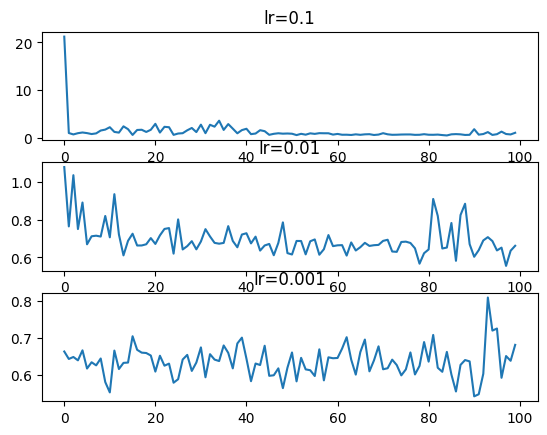

In [11]:
# TODO: augmentáció a centroidok körül
# Nemlinearitast kulon hozza kell adni
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn.conv import TransformerConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Batch
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Define the Graph Neural Network (GNN) model
class GNN(nn.Module):
    def __init__(self, input_node_dim, input_edge_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.transformer1 = TransformerConv(
            input_node_dim, hidden_dim, edge_dim=input_edge_dim
        )
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, data: Batch):
        x = self.transformer1(x=data.x, edge_index=data.edge_index, edge_attr=data.edge_attr)
        x = global_mean_pool(x, batch=data.batch)
        x = self.fc2(x).squeeze()
        x = self.sigmoid(x)
        return x

# Define training loop
def train_loop(dataloader, model, loss_fn, optimizer, _print: bool):
    losses = []
    size = len(dataloader.dataset)
    model.train()
    for batch, data in enumerate(dataloader):
        # Compute prediction and loss
        data = data.to(device)
        pred = model(data)
        loss = loss_fn(pred, data.y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 2 == 0:
            loss, current = loss.item(), (batch + 1) * len(data)
            if _print:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            losses.append(loss)
            # with torch.no_grad():
            #     acc = torch.mean(((pred > 0.5) == data.y).float())
            #     print(f"{acc=}")
    
    return losses   
        
# Create GNN model
input_node_dim = 87
input_edge_dim = 4  # Adjust if your edge features have a different dimension
hidden_dim = 100
output_dim = 1  # Binary classification

model = GNN(input_node_dim, input_edge_dim, hidden_dim, output_dim)
model = model.to(device)

criterion = nn.BCELoss()
fig, axes = plt.subplots(3, 1)
for lr, ax in zip([0.1, 0.01, 0.001], axes):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    epochs = 10
    losses = []
    for t in range(epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        losses += train_loop(data_loader, model, criterion, optimizer, _print=False)
        # test_loop(test_dataloader, model, loss_fn)
    print("Done!")
    ax.set_title(f"{lr=}")
    ax.plot(losses)


In [13]:
# Evaluate accuracy:
model.eval()
for batch, data in enumerate(data_loader):
    # Compute prediction and loss
    data = data.to(device)
    pred = model(data)
    acc = torch.mean(((pred > 0.5) == data.y).float())
    print(acc)

tensor(0.5938, device='cuda:0')
tensor(0.5625, device='cuda:0')
tensor(0.4375, device='cuda:0')
tensor(0.6875, device='cuda:0')
tensor(0.6250, device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor(0.7812, device='cuda:0')
tensor(0.6250, device='cuda:0')
tensor(0.6250, device='cuda:0')
tensor(0.6875, device='cuda:0')
tensor(0.6562, device='cuda:0')
tensor(0.5312, device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor(0.4688, device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(0.5625, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.6250, device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor(0., device='cuda:0')


In [ ]:
# Ha nem működik: duális gráf.            
# Teljesen felépíteni a pipeline-okat.
# FC az edge feature-ökre

## Age regression

In [14]:
dataset_list = []

for name in labels.keys():
    x = torch.eye(87) # node features
    edge_index = torch.tensor(
        [[i, j] for i in range(87) for j in range(87)],
        dtype=torch.long).t().contiguous()
    edge_attr = torch.Tensor(connectomes[name])
    edge_attr = edge_attr.reshape((-1, 4))

    y = torch.Tensor([labels[name].birth_age])

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    dataset_list.append(data)
    
torch.random.manual_seed(42)
data_loader = DataLoader(dataset_list, batch_size=32, shuffle=True)

Done!
Done!
Done!


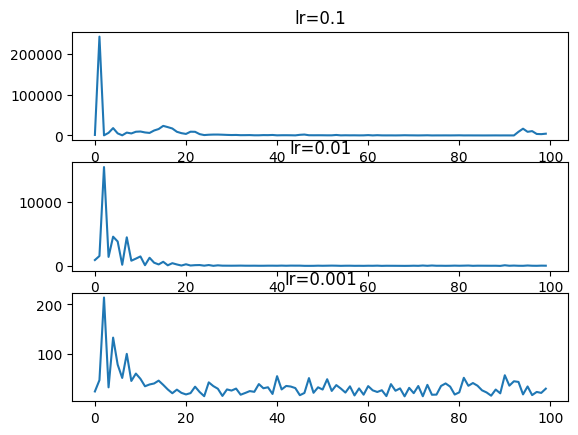

In [15]:
# Define the Graph Neural Network (GNN) model
class GNN(nn.Module):
    def __init__(self, input_node_dim, input_edge_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.transformer1 = TransformerConv(
            input_node_dim, hidden_dim, edge_dim=input_edge_dim
        )
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, data: Batch):
        x = self.transformer1(x=data.x, edge_index=data.edge_index, edge_attr=data.edge_attr)
        x = global_mean_pool(x, batch=data.batch)
        x = self.fc2(x).squeeze()
        # x = self.sigmoid(x) no sigmoid for regression
        return x

# Define training loop
def train_loop(dataloader, model, loss_fn, optimizer, _print: bool):
    losses = []
    size = len(dataloader.dataset)
    model.train()
    for batch, data in enumerate(dataloader):
        # Compute prediction and loss
        data = data.to(device)
        pred = model(data)
        loss = loss_fn(pred, data.y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 2 == 0:
            loss, current = loss.item(), (batch + 1) * len(data)
            if _print:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            losses.append(loss)
            # with torch.no_grad():
            #     acc = torch.mean(((pred > 0.5) == data.y).float())
            #     print(f"{acc=}")
    
    return losses   
        
# Create GNN model
input_node_dim = 87
input_edge_dim = 4  # Adjust if your edge features have a different dimension
hidden_dim = 100
output_dim = 1  # Binary classification

model = GNN(input_node_dim, input_edge_dim, hidden_dim, output_dim)
model = model.to(device)

criterion = nn.MSELoss()
fig, axes = plt.subplots(3, 1)
for lr, ax in zip([0.1, 0.01, 0.001], axes):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    epochs = 10
    losses = []
    for t in range(epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        losses += train_loop(data_loader, model, criterion, optimizer, _print=False)
        # test_loop(test_dataloader, model, loss_fn)
    print("Done!")
    ax.set_title(f"{lr=}")
    ax.plot(losses)

In [16]:
# Evaluate accuracy:
model.eval()
for batch, data in enumerate(data_loader):
    # Compute prediction and loss
    data = data.to(device)
    pred = model(data)
    mae = torch.mean(torch.abs(pred - data.y))
    print(mae)

tensor(3.4947, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.5547, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.9558, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.9685, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.9567, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.9475, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.1862, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7507, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.2538, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.6799, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.0436, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1346, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.4866, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2079, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.6942, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.9305, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0909, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.5841, device='cuda:0',